<p align="center">Hoang Anh Nguyen</p>

# EXERCISE 1

In [43]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

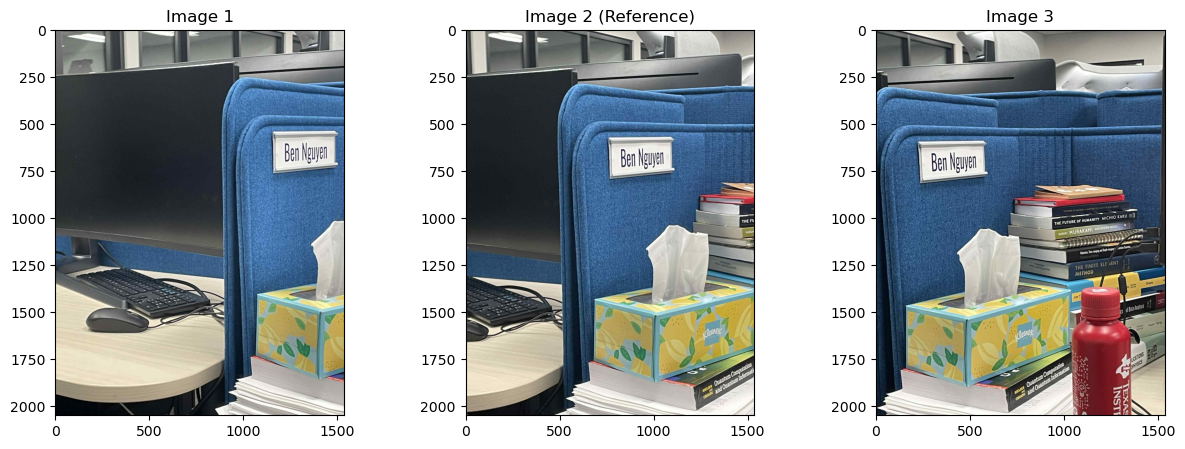

In [44]:
img1 = cv.cvtColor(cv.imread('homo_input/1.jpeg'), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread('homo_input/2.jpeg'), cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(cv.imread('homo_input/3.jpeg'), cv.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.title('Image 1')

plt.subplot(1,3,2)
plt.imshow(img2)
plt.title('Image 2 (Reference)')

plt.subplot(1,3,3)
plt.imshow(img3)
plt.title('Image 3')
plt.show()


In [45]:
# extract SIFT features
sift = cv.SIFT_create()

# SIFT descriptors for all three images
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)

# match features using FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
matcher = cv.FlannBasedMatcher(index_params, search_params)

# Match img1 to img2
matches_12 = matcher.knnMatch(des1, des2, k=2)

# Lowe's ratio test for img1-img2
good_matches_12 = []
for m_n in matches_12:
    m, n = m_n
    if m.distance < 0.75 * n.distance:
        good_matches_12.append(m)

# Match img2 to img3
matches_23 = matcher.knnMatch(des2, des3, k=2)

# Lowe's ratio test for img2-img3
good_matches_23 = []
for m_n in matches_23:
    m, n = m_n
    if m.distance < 0.75 * n.distance:
        good_matches_23.append(m)

print(f"Found {len(good_matches_12)} good matches between image 1 and 2.")
print(f"Found {len(good_matches_23)} good matches between image 2 and 3.")


Found 1197 good matches between image 1 and 2.
Found 1526 good matches between image 2 and 3.


Homography Matrix from Image 1 to Image 2:
[[ 1.03145873e+00  5.30656822e-03 -4.28011834e+02]
 [ 7.28345377e-03  9.95624858e-01  3.20436752e+01]
 [ 1.37437712e-05 -7.18627362e-06  1.00000000e+00]]

Homography Matrix from Image 2 to Image 3:
[[ 1.06290568e+00  4.57133558e-03 -5.70503965e+02]
 [ 7.50713024e-03  1.04134688e+00  8.04307474e+00]
 [ 3.06680971e-05  3.77555633e-06  1.00000000e+00]]



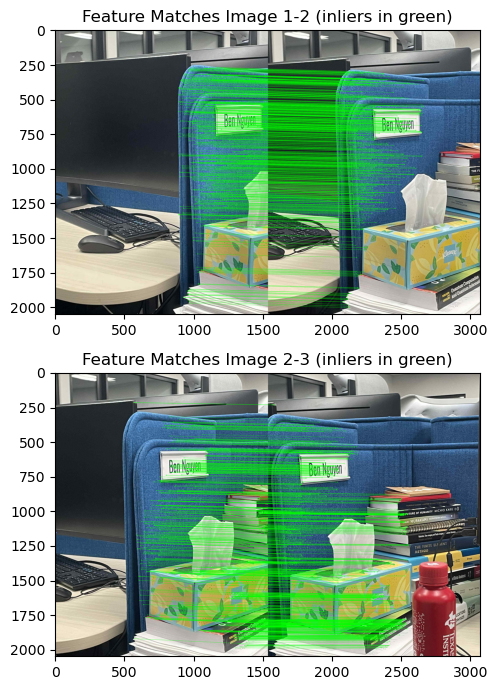

In [46]:
# Estimate Homography with RANSAC for img1 to img2
src_pts_12 = np.float32([kp1[m.queryIdx].pt for m in good_matches_12]).reshape(-1,1,2)
dst_pts_12 = np.float32([kp2[m.trainIdx].pt for m in good_matches_12]).reshape(-1,1,2)
H_12, mask_12 = cv.findHomography(src_pts_12, dst_pts_12, cv.RANSAC, 5.0)
matches_mask_12 = mask_12.ravel().tolist()

print("Homography Matrix from Image 1 to Image 2:")
print(H_12)
print()

# Estimate Homography with RANSAC for img2 to img3
src_pts_23 = np.float32([kp2[m.queryIdx].pt for m in good_matches_23]).reshape(-1,1,2)
dst_pts_23 = np.float32([kp3[m.trainIdx].pt for m in good_matches_23]).reshape(-1,1,2)
H_23, mask_23 = cv.findHomography(src_pts_23, dst_pts_23, cv.RANSAC, 5.0)
matches_mask_23 = mask_23.ravel().tolist()

print("Homography Matrix from Image 2 to Image 3:")
print(H_23)
print()

# Display inlier matches for both pairs
draw_params_12 = dict(matchColor=(0,255,0), singlePointColor=None, matchesMask=matches_mask_12, flags=2)
matched_img_12 = cv.drawMatches(img1, kp1, img2, kp2, good_matches_12, None, **draw_params_12)

draw_params_23 = dict(matchColor=(0,255,0), singlePointColor=None, matchesMask=matches_mask_23, flags=2)
matched_img_23 = cv.drawMatches(img2, kp2, img3, kp3, good_matches_23, None, **draw_params_23)

plt.figure(figsize=(15, 7))
plt.subplot(2,1,1)
plt.imshow(matched_img_12)
plt.title("Feature Matches Image 1-2 (inliers in green)")
plt.subplot(2,1,2)
plt.imshow(matched_img_23)
plt.title("Feature Matches Image 2-3 (inliers in green)")
plt.tight_layout()
plt.show()


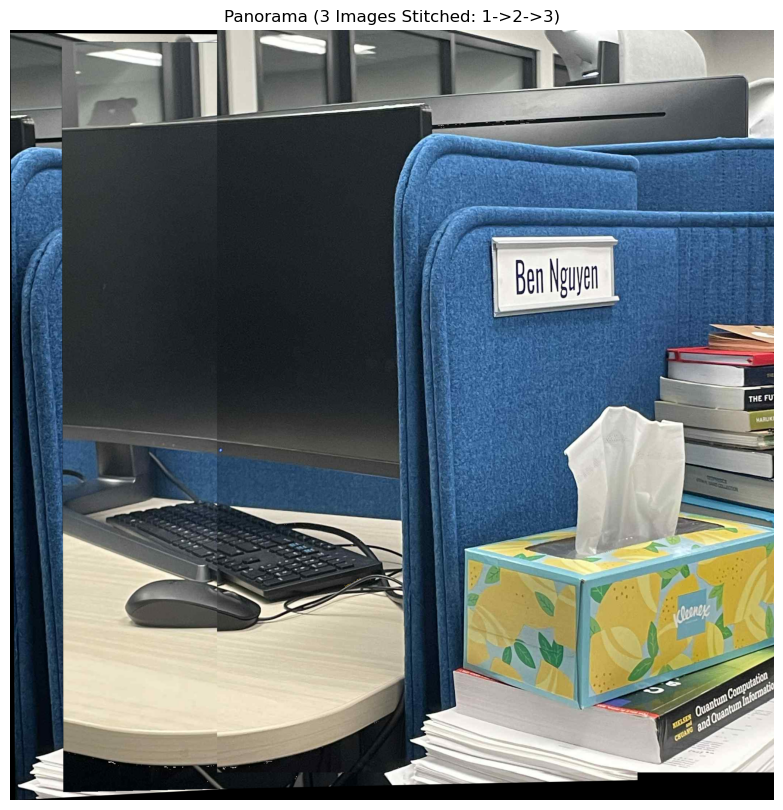

In [47]:
# Create 3-image panorama by chaining transformations
# Strategy: Stitch img1 to img2 first, then stitch img3 to the result

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
h3, w3 = img3.shape[:2]

# Step 1: Stitch img1 and img2 first
# Compute corners of img1 in img2's coordinate system
corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
warped_corners_1 = cv.perspectiveTransform(corners_img1, H_12)

# Combine corners to find panorama extents for img1+img2
corners_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)
all_corners_12 = np.concatenate((warped_corners_1, corners_img2), axis=0)

[xmin_12, ymin_12] = np.int32(all_corners_12.min(axis=0).ravel() - 0.5)
[xmax_12, ymax_12] = np.int32(all_corners_12.max(axis=0).ravel() + 0.5)

# Translation to avoid negative coordinates for img1+img2 panorama
translation_12 = [-xmin_12, -ymin_12]
T_12 = np.array([[1, 0, translation_12[0]], [0, 1, translation_12[1]], [0, 0, 1]], dtype=np.float32)

# Create intermediate panorama (img1 + img2)
panorama_12 = cv.warpPerspective(img1, T_12 @ H_12, (xmax_12 - xmin_12, ymax_12 - ymin_12))
panorama_12[translation_12[1]:h2 + translation_12[1], translation_12[0]:w2 + translation_12[0]] = img2

# Step 2: Now stitch img3 to the panorama_12
# The homography from img2 to img3 is H_23
# But we need to account for where img2 is positioned in panorama_12
# img2's position in panorama_12 is offset by translation_12

# Create a transformation that places img2's coordinates in the panorama_12 space
T_img2_in_pano12 = np.array([[1, 0, translation_12[0]], [0, 1, translation_12[1]], [0, 0, 1]], dtype=np.float32)

# The transformation from img3 to panorama_12 space is:
# First go from img3 to img2 (H_23), then from img2 to panorama_12 (T_img2_in_pano12)
H_3_to_pano12 = T_img2_in_pano12 @ H_23

# Compute where img3's corners will be in the panorama_12 space
corners_img3 = np.float32([[0,0], [0,h3], [w3,h3], [w3,0]]).reshape(-1,1,2)
warped_corners_3 = cv.perspectiveTransform(corners_img3, H_3_to_pano12)

# Get dimensions of panorama_12
h_pano12, w_pano12 = panorama_12.shape[:2]
corners_pano12 = np.float32([[0,0], [0,h_pano12], [w_pano12,h_pano12], [w_pano12,0]]).reshape(-1,1,2)

# Combine all corners for final panorama
all_corners_final = np.concatenate((corners_pano12, warped_corners_3), axis=0)

[xmin_final, ymin_final] = np.int32(all_corners_final.min(axis=0).ravel() - 0.5)
[xmax_final, ymax_final] = np.int32(all_corners_final.max(axis=0).ravel() + 0.5)

# Translation for final panorama
translation_final = [-xmin_final, -ymin_final]
T_final = np.array([[1, 0, translation_final[0]], [0, 1, translation_final[1]], [0, 0, 1]], dtype=np.float32)

# Warp panorama_12 into final canvas
result = cv.warpPerspective(panorama_12, T_final, (xmax_final - xmin_final, ymax_final - ymin_final))

# Warp img3 into final canvas
warped_img3 = cv.warpPerspective(img3, T_final @ H_3_to_pano12, (xmax_final - xmin_final, ymax_final - ymin_final))

# Blend img3 into result (only where result is black/empty)
mask_result_empty = (result.sum(axis=2) == 0)
result[mask_result_empty] = warped_img3[mask_result_empty]

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.title("Panorama (3 Images Stitched: 1->2->3)")
plt.axis('off')
plt.show()


# EXERCISE 2